# Shapiro Wilk Test

In [1]:
# Load packages
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(openair))

suppressMessages(library(plyr))

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

## Representative sample 

In [4]:
sites.lv <- c("es0118a", "es1438a") # Big cities (Madrid and Barcelona)",
sites.lv <- c(sites.lv, "es1580a", "es1340a") # small cities (Santander and Huelva)

## DataFrame Creation

In [5]:
# Create dataSet
load("data/data_AQ.rda")
load("data/meteorology.rda")

aq <- data_AQ %>%
            filter(site %in% sites.lv,
                   date < ymd("2020-01-01")
                  ) %>%
            #pivot_wider(names_from = variable, values_from = value) %>%
            timeAverage(avg.time = "day", type=c("site", "variable"))
aq$date <- as_date(aq$date)

mto <- data_Mto %>%
            filter(site %in% sites.lv,
                   date < ymd("2020-01-01"))

df <- merge(aq, mto,
              by = c("date", "site"), all.x=T) %>%
        mutate_if(is.factor, as.character) %>%
        drop_na() %>%
        select(-date_end, -process, -summary, -validity)

rm(data_AQ)
rm(data_Mto)

In [6]:
deseason <- function(cl) {
    # Remove seasonal component of the additive time serie.
    #     This function is called below by an apply

    dcomp <- decompose(ts(cl, frequency = 365))

    cl - dcomp$seasonal
}

In [7]:
my.shapiro.test <- function(cl) {
    
    sh <- shapiro.test(cl)
    
    data.frame(W=sh$statistic, p.value=sh$p.value)
}

In [8]:
all <- data.frame()

for (st in sites.lv) {
    dat <- df[df$site == st,] 
    for(pll in levels(as.factor(dat$variable))) {
        pll.dat <- dat[dat$variable == pll, ]
        
        if (sum(!is.na(pll.dat$date)) > (365*2)) {
            pll.dat <- cbind(pll.dat[, 1:3], apply(pll.dat[, -1:-3], 2, deseason))
        }

        a <- apply(pll.dat[, -1:-3], 2, my.shapiro.test)
        
        for (nm in names(a)) {
            if (a[[nm]]$p.value > 0.005) {
                print(paste(st, pll, nm))
            }
        }
    }
}

[1] "es0118a o3 value"
[1] "es1340a no tmed"
[1] "es1340a no tmax"
[1] "es1340a no RH"
[1] "es1340a no2 tmed"
[1] "es1340a no2 tmax"
[1] "es1340a no2 RH"
[1] "es1340a pm10 RH"


In [9]:
a <- shapiro.test(df[df$site == "es1340a" &
                df$variable == "no", "value"])

In [10]:
a
a$p.value


	Shapiro-Wilk normality test

data:  df[df$site == "es1340a" & df$variable == "no", "value"]
W = 0.71713, p-value < 2.2e-16


[1] 6.552263e-48

In [11]:
a$statistic

W 
0.7171336

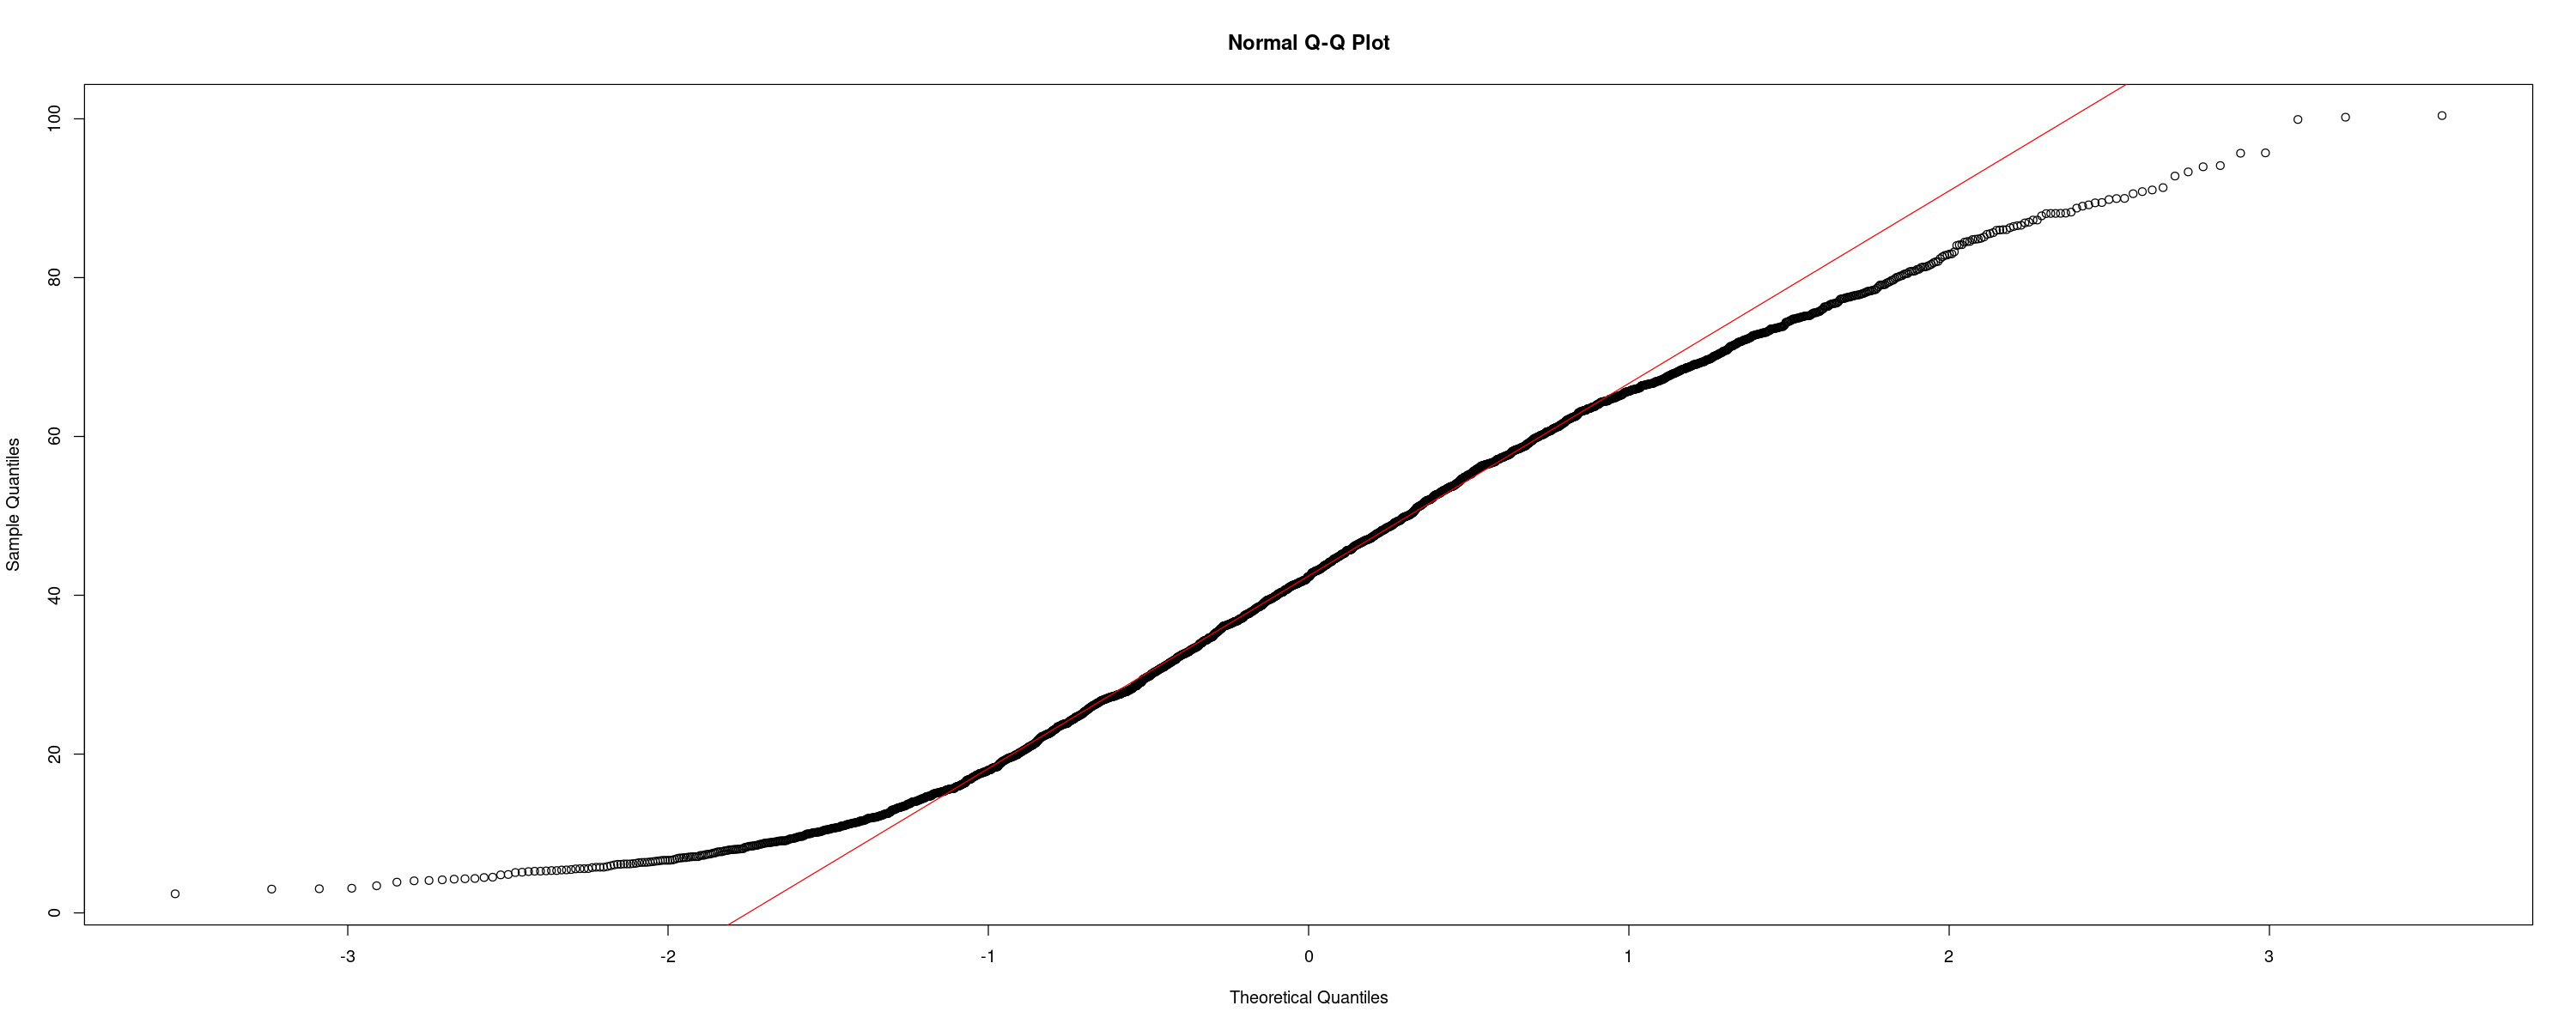

In [12]:
library(graphics)

qqnorm(df[df$site == "es0118a" &
                df$variable == "o3", "value"])
qqline(df[df$site == "es0118a" &
                df$variable == "o3", "value"], col="red")